# Random Forest

## Import and load data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
X_train = pd.read_csv('../data/processed/X_train_rf.csv')
y_train = pd.read_csv('../data/processed/y_train_rf.csv')
X_test = pd.read_csv('../data/processed/X_test_rf.csv')
y_train = y_train['SalePrice']

In [3]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)

Training Features Shape: (1460, 66)
Training Target Shape: (1460,)
Testing Features Shape: (1459, 67)


### Helper functions

In [17]:
# Show all rows and columns of data frame
def print_all(x):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_rows')

# Feature importance plots
def feat_df(feature_names, importances):
    df=pd.DataFrame({'feature': feature_names,
                     'importance': importances}).sort_values('importance', ascending=False).reset_index(drop=True)
    return df

def plot_imp(feat_df, title):
    feat_df.columns=['feature', 'importance']
    sns.barplot(x='importance', y='feature', data=feat_df, orient='h',palette='Spectral').set_title(title, fontsize = 20)
    sns.set(rc = {'figure.figsize':(10, 10)})

## Model

In [5]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint

In [6]:
# Create base model
rf = RandomForestRegressor(random_state = 999)

In [7]:
# Check out base/default parameters
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 999,
 'verbose': 0,
 'warm_start': False}


### Choose hyperparameters

#### Randomized Search

Narrow down search for wide range of values for hyperparameters:

In [8]:
from sklearn.model_selection import RandomizedSearchCV

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2000, stop = 3500, num = 10)]
# Number of features to consider at every split
max_features = [7, 8, 9, 10, 11, 12, 15, 16, 20, 22]
# Minimum number of samples required to split a node
min_samples_split = [8, 9, 10]
# Out of bag estimate
oob_score = [True]

In [10]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'oob_score': oob_score
              }

In [11]:
pprint(random_grid)

{'max_features': [7, 8, 9, 10, 11, 12, 15, 16, 20, 22],
 'min_samples_split': [8, 9, 10],
 'n_estimators': [2000, 2166, 2333, 2500, 2666, 2833, 3000, 3166, 3333, 3500],
 'oob_score': [True]}


In [12]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 5-fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=9

In [13]:
rf_random.best_params_

{'oob_score': True,
 'n_estimators': 3500,
 'min_samples_split': 8,
 'max_features': 20}

In [15]:
random_scores = pd.DataFrame(rf_random.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
random_scores = random_scores.set_index(['rank_test_score', 'mean_test_score', 'std_test_score']).params.apply(pd.Series).drop('oob_score',1).reset_index()
random_scores_top_10 = random_scores.sort_values('rank_test_score')[:11]
random_scores_top_10

,rank_test_score,mean_test_score,std_test_score,n_estimators,min_samples_split,max_features
77,1,0.873302,0.015488,3500,8,20
58,2,0.873260,0.015556,3000,8,20
51,3,0.873245,0.015622,2666,8,20
69,4,0.873218,0.014041,2000,8,15
89,5,0.873206,0.013939,2333,8,15
81,6,0.873189,0.015752,2500,8,22
10,7,0.873184,0.015957,2000,8,22
2,8,0.873156,0.015771,3333,8,22
23,9,0.873154,0.015752,3500,8,22
80,10,0.873089,0.014069,2833,8,15


Calculate R^2 (coefficient of determination) score, mean test score, oob_score, and mean training error of `rf_random` model using best parameters:

In [16]:
from sklearn.metrics import r2_score

In [20]:
print('R^2 score: %.5f' %(r2_score(y_train, rf_random.predict(X_train))))
print('Mean test score: %.5f' %(rf_random.best_score_))
print('OOB score: %.5f' %(rf_random.best_estimator_.oob_score_))
print('Training error: %.5f' %(1 - rf_random.score(X_train, y_train)))

R^2 score: 0.96811
Mean test score: 0.87330
OOB score: 0.87994
Training error: 0.03189


#### Grid Search

Evaluate combination of settings from randomized search:

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
random_scores_top_10.describe()

,rank_test_score,mean_test_score,std_test_score,n_estimators,min_samples_split,max_features
count,11.000000,11.000000,11.000000,11.000000,11.0,11.000000
mean,6.000000,0.873189,0.015091,2787.727273,8.0,18.909091
std,3.316625,0.000069,0.000853,543.099087,0.0,3.207945
min,1.000000,0.873074,0.013939,2000.000000,8.0,15.000000
25%,3.500000,0.873155,0.014065,2416.500000,8.0,15.000000
50%,6.000000,0.873189,0.015556,2833.000000,8.0,20.000000
75%,8.500000,0.873232,0.015752,3166.500000,8.0,22.000000
max,11.000000,0.873302,0.015957,3500.000000,8.0,22.000000


In [24]:
param_grid = {
    'max_features': [15, 16, 18, 20, 22],
    'min_samples_split': [7, 8, 9],
    'n_estimators': [2000, 2400, 2500, 2800, 3166],
    'oob_score': [True]
}

In [25]:
# Use gridSearchCV to search to narrow down parameters
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 5, n_jobs = -1, verbose = 2)

# Fit the random search model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 14.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=999,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': [15, 16, 18, 20, 2

In [26]:
grid_search.best_params_

{'max_features': 20,
 'min_samples_split': 7,
 'n_estimators': 2000,
 'oob_score': True}

In [27]:
grid_scores = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
grid_scores = grid_scores.set_index(['rank_test_score', 'mean_test_score', 'std_test_score']).params.apply(pd.Series).drop('oob_score',1).reset_index()
grid_scores.sort_values('rank_test_score')[:11]

,rank_test_score,mean_test_score,std_test_score,max_features,min_samples_split,n_estimators
45,1,0.873941,0.015156,20,7,2000
47,2,0.873918,0.015122,20,7,2500
49,3,0.873911,0.015138,20,7,3166
46,4,0.873902,0.015136,20,7,2400
33,5,0.873859,0.015107,18,7,2800
31,6,0.873835,0.015103,18,7,2400
48,7,0.873826,0.015182,20,7,2800
32,8,0.873797,0.015127,18,7,2500
30,9,0.873760,0.015115,18,7,2000
34,10,0.873755,0.015118,18,7,3166


Calculate R^2 (coefficient of determination) score, mean test score, oob_score, and mean training error of `grid_search` model using best parameters:

In [28]:
print('R^2 score: %.5f' %(r2_score(y_train, grid_search.predict(X_train))))
print('Mean test score: %.5f' %(grid_search.best_score_))
print('OOB score: %.5f' %(grid_search.best_estimator_.oob_score_))
print('Training error: %.5f' %(1 - grid_search.score(X_train, y_train)))

R^2 score: 0.97070
Mean test score: 0.87394
OOB score: 0.87985
Training error: 0.02930


## Feature importance

### Measure: mean decrease in impurity (variance)

The default measure of feature importance in scikit-learn is mean decrease in impurity, which refers to variance (regression trees) or Gini impurity/entropy (classification trees).

Some things to keep in mind about mean decrease in purity:

- Biased towards preferring features with more categories ([Strobl, et. al (2007)](https://link.springer.com/article/10.1186%2F1471-2105-8-25))
- Less reliable when it comes to features with differing scale of measurements ([Strobl, et. al (2007)](https://link.springer.com/article/10.1186%2F1471-2105-8-25))
- One of the correlated features will be artificially ranked in importance because "from the point of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others" ([T. Parr, et. al (2018)](https://explained.ai/rf-importance/))

Calculate feature importance using `sklearn`'s default mean decrease in impurity mechanism:

In [29]:
rf_features = list(X_train.columns)

importances = list(grid_search.best_estimator_.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature,
                      importance in zip(rf_features, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances][0]

Feature: Neighborhood         Importance: 0.19
Feature: GrLivArea            Importance: 0.17
Feature: YearBuilt            Importance: 0.09
Feature: TotalBsmtSF          Importance: 0.06
Feature: GarageCars           Importance: 0.06
Feature: 1stFlrSF             Importance: 0.05
Feature: GarageArea           Importance: 0.05
Feature: OverallQual          Importance: 0.03
Feature: GarageYrBlt          Importance: 0.03
Feature: GarageFinish         Importance: 0.03
Feature: MSSubClass           Importance: 0.02
Feature: LotArea              Importance: 0.02
Feature: YearRemodAdd         Importance: 0.02
Feature: 2ndFlrSF             Importance: 0.02
Feature: FireplaceQu          Importance: 0.02
Feature: MSZoning             Importance: 0.01
Feature: LotFrontage          Importance: 0.01
Feature: ExterQual            Importance: 0.01
Feature: Foundation           Importance: 0.01
Feature: BsmtQual             Importance: 0.01
Feature: CentralAir           Importance: 0.01
Feature: Kitc

### Measure: Permutation importance

Permutation importance measures feature importance by permuting the values of each predictor feature to measure model performance. The advantage of this method is that it preserves the distribution of the feature and generally gives more reliable results than mean decrease in purity. In detail:

1. Pass a validation set or out-of-bag (OOB) samples through Random Forest to record baseline accuracy (classifier) or R^2 score (regressor)
2. Randomly reshuffle values of a predictor feature
3. Pass all test samples back through Random Forest and recompute accuracy or R^2
4. Calculate difference between the baseline accuracy or R^2 and the drop in overall accuracy or R^2 after reshuffling

Calculate permutation feature importance using `rfpimp`:

In [30]:
from rfpimp import *

In [31]:
def r2(grid_search, X_train, y_train):
    return r2_score(y_train, grid_search.predict(X_train))

rfpimp_perm = permutation_importances(grid_search, X_train, y_train, r2)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 14.7min finished


In [70]:
rfpimp_perm = rfpimp_perm.reset_index()
print_all(rfpimp_perm.sort_values(by='Importance', ascending = False))

              Feature  Importance
0           GrLivArea    0.153156
1        Neighborhood    0.100231
2         TotalBsmtSF    0.037151
3           YearBuilt    0.029625
4            1stFlrSF    0.028160
5         OverallQual    0.021757
6          GarageArea    0.019712
7          GarageCars    0.017956
8        YearRemodAdd    0.011277
9             LotArea    0.011239
10           2ndFlrSF    0.008659
11        FireplaceQu    0.008513
12         Fireplaces    0.008051
13        GarageYrBlt    0.008004
14         CentralAir    0.007630
15  TotalPorchAreasSF    0.007222
16         MSSubClass    0.007014
17       GarageFinish    0.006043
18          TotalBath    0.004307
19        LotFrontage    0.004050
20        OverallCond    0.003731
21        KitchenQual    0.003628
22           BsmtQual    0.003304
23           MSZoning    0.003284
24       BsmtFinType1    0.003236
25          ExterQual    0.002432
26             MoSold    0.002107
27         MasVnrArea    0.002000
28      SaleCo

### Measure: Drop-column importance

Drop-column importance investigates feature importance by comparing the performance score of a reduced model with a dropped feature to the performance score of a baseline model with all features. In detail:

1. Determine performance score of baseline model with permutation importance
2. Drop a column
3. Retrain model
4. Recompute performance score of reduced model with dropped feature
5. Calculate the difference between baseline performance score and performaence score of reduced model

The key advantage of drop-column importance is that it measures feature importance more directly than even permutation importance, and thus provides a "ground truth" for feature importance ([T. Parr, et. al (2018)](https://explained.ai/rf-importance/)).

One thing to keep in mind: the importance value may change between retrainings, but the order of importance should remain the same.

Use `rfpimp` to implement drop-column importance:

In [64]:
rf_saturated = RandomForestRegressor(n_estimators = 2000, min_samples_split = 7, 
                                     max_features = 20, random_state = 999,
                                     oob_score = True, n_jobs = -1)

In [65]:
drop_col_feat = dropcol_importances(rf_saturated, X_train, y_train)

In [66]:
print_all(drop_col_feat.sort_values('Importance', ascending = False))

                   Importance
Feature                      
GrLivArea            0.001925
Neighborhood         0.001399
OverallQual          0.000981
YearRemodAdd         0.000557
LotArea              0.000329
CentralAir           0.000275
TotalBsmtSF          0.000230
MSZoning             0.000222
TotalPorchAreasSF    0.000214
OverallCond          0.000151
BsmtFinType1         0.000111
1stFlrSF             0.000084
Functional           0.000075
TotalBath            0.000073
GarageYrBlt          0.000068
KitchenQual          0.000036
BedroomAbvGr         0.000027
YrSold               0.000023
FireplaceQu          0.000005
GarageType           0.000001
SaleCondition       -0.000004
YearBuilt           -0.000021
2ndFlrSF            -0.000036
HeatingQC           -0.000051
Fireplaces          -0.000072
MoSold              -0.000074
Exterior1st         -0.000087
BsmtCond            -0.000091
BsmtFinType2        -0.000094
OtherRoomsAbvGrd    -0.000105
Alley               -0.000116
GarageFini

### Conditional feature importance

Identify indexes with the lowest and highest absolute prediction errors, which represent best and worst predictions:

In [67]:
pred_diff = pd.DataFrame({'difference': abs(y_train - rf_saturated.fit(X_train, y_train).predict(X_train))})

print('Index with smallest error:', pred_diff.sort_values('difference').head(1).index.values[0])
print('Inxex with largest error:', pred_diff.sort_values('difference', ascending = False).head(1).index.values[0])

Index with smallest error: 1444
Inxex with largest error: 1397


Explanation here:

In [445]:
from treeinterpreter import treeinterpreter as ti, utils

In [446]:
selected_rows = [1444, 1397]
selected_df = X_train.iloc[selected_rows,:].values
prediction, bias, contributions = ti.predict(rf_saturated, selected_df)

for i in range(len(selected_rows)):
    print("Row", selected_rows[i])
    print("Prediction:", prediction[i][0])
    print("Actual Value:", y_train[selected_rows[i]])
    print("Bias (trainset mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 X_train.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20)

Row 1444
Prediction: 11.732024221692335
Actual Value: 11.732069026983154
Bias (trainset mean) 12.024077228081843
Feature contributions:
GrLivArea -0.12
Neighborhood -0.04
1stFlrSF -0.03
GarageCars -0.03
TotalBath -0.02
GarageArea -0.02
GarageFinish -0.02
TotalBsmtSF -0.01
FireplaceQu -0.01
Fireplaces -0.01
GarageYrBlt -0.01
YearRemodAdd 0.01
BsmtFinType1 0.01
MSSubClass 0.01
CentralAir 0.01
2ndFlrSF -0.01
OverallQual 0.01
LotFrontage 0.01
OverallCond 0.01
YearBuilt -0.01
GarageQual 0.01
GarageCond 0.0
SaleCondition 0.0
LotArea -0.0
Foundation -0.0
MoSold 0.0
TotalPorchAreasSF 0.0
MSZoning 0.0
HouseStyle -0.0
BsmtExposure 0.0
BedroomAbvGr -0.0
ExterQual -0.0
PavedDrive 0.0
BsmtCond 0.0
HeatingQC -0.0
Exterior2nd 0.0
MasVnrArea -0.0
OtherRoomsAbvGrd -0.0
BsmtFinType2 0.0
Remodeled -0.0
KitchenQual -0.0
YrSold 0.0
RoofStyle -0.0
LotConfig -0.0
GarageType 0.0
Condition1 0.0
BsmtQual 0.0
SaleType 0.0
Fence 0.0
Electrical 0.0
MasVnrType -0.0
BldgType 0.0
ExterCond -0.0
LotShape -0.0
LandCont

In [447]:
prediction1, bias1, contributions1 = ti.predict(rf_saturated, np.array([selected_df[0]]), joint_contribution=True)
prediction2, bias2, contributions2 = ti.predict(rf_saturated, np.array([selected_df[1]]), joint_contribution=True)

In [448]:
aggregated_contributions1 = utils.aggregated_contribution(contributions1)
aggregated_contributions2 = utils.aggregated_contribution(contributions2)

In [449]:
print (np.sum(list(aggregated_contributions1.values())) - 
       np.sum(list(aggregated_contributions2.values())))
print (np.mean(prediction1) - np.mean(prediction2))

0.7016204846851974
0.7016204846851988


In [450]:
res = []
for k in set(aggregated_contributions1.keys()).union(
              set(aggregated_contributions2.keys())):
    res.append(([X_train.columns[index] for index in k] , 
               aggregated_contributions1.get(k, 0) - aggregated_contributions2.get(k, 0)))   
         
for lst, v in (sorted(res, key=lambda x:-abs(x[1])))[:10]:
    print (lst, v)

['YearBuilt'] [0.01775403]
['Neighborhood', 'OverallQual'] [0.00981704]
['YearBuilt', 'GrLivArea'] [0.00894106]
['Neighborhood', 'CentralAir', 'GrLivArea'] [0.00833738]
['Neighborhood', 'GrLivArea'] [0.00773907]
['Neighborhood', 'OverallQual', '1stFlrSF'] [0.00721883]
['CentralAir', 'GrLivArea'] [0.00659343]
['YearBuilt', 'CentralAir', 'GrLivArea'] [0.00467642]
['Neighborhood', 'OverallQual', 'TotalBsmtSF'] [0.00431424]
['TotalBsmtSF', 'CentralAir', 'GrLivArea'] [0.00417119]


In [45]:
# #print_all(pred_diff.sort_values('difference').agg({'mean', 'median'}))
# #print_all(pred_diff.sort_values('difference'))

# selected_rows2 = [788,1444]
# selected_df2 = X_train.iloc[selected_rows2,:].values
# prediction4, bias4, contributions4 = ti.predict(rf_saturated, selected_df2)

# for i in range(len(selected_rows2)):
#     print("Row", selected_rows2[i])
#     print("Prediction:", prediction4[i][0])
#     print("Actual Value:", y_train[selected_rows2[i]])
#     print("Bias (trainset mean)", bias[i])
#     print("Feature contributions:")
#     for c, feature in sorted(zip(contributions4[i], 
#                                  X_train.columns), 
#                              key=lambda x: -abs(x[0])):
#         print(feature, round(c, 2))
#     print("-"*20)

Row 788
Prediction: 11.803286276379433
Actual Value: 11.849404844423075
Bias (trainset mean) 12.024077228081843
Feature contributions:
Neighborhood -0.14
GrLivArea -0.11
GarageArea 0.04
GarageFinish -0.02
GarageCars 0.02
FireplaceQu -0.02
1stFlrSF -0.02
BsmtFinType1 0.02
Fireplaces -0.02
TotalBath 0.01
OverallQual 0.01
YearRemodAdd 0.01
GarageYrBlt -0.01
TotalBsmtSF 0.01
CentralAir 0.01
LotFrontage -0.01
2ndFlrSF -0.01
GarageType -0.01
YearBuilt -0.01
MSZoning -0.0
LotArea -0.0
BsmtQual 0.0
Foundation -0.0
GarageQual 0.0
MasVnrArea 0.0
TotalPorchAreasSF -0.0
BedroomAbvGr -0.0
MSSubClass -0.0
GarageCond 0.0
BsmtExposure 0.0
SaleCondition 0.0
MasVnrType 0.0
ExterQual -0.0
PavedDrive 0.0
MoSold 0.0
KitchenQual -0.0
OverallCond 0.0
HeatingQC -0.0
HouseStyle 0.0
Electrical 0.0
BsmtCond 0.0
OtherRoomsAbvGrd 0.0
Exterior2nd 0.0
Fence -0.0
Functional 0.0
YrSold -0.0
LotShape -0.0
Exterior1st 0.0
SaleType 0.0
ExterCond 0.0
LotConfig -0.0
MiscVal 0.0
Condition1 0.0
LandContour 0.0
Condition2 0.0

In [53]:
print(np.exp(11.803286276379433))
print(np.exp(11.849404844423075))
print(np.exp(12.024077228081843))

133690.9773312511
140001.00000000017
166721.03208914047


### Investigating multicollinearity and feature dependence

#### Multicollinearity

Multicollinearity is calculated using Spearman's rank-order correlation, which involves converting two predictor features to rank values and then running a standard Pearson's correlation on those ranked variables. The key advantage of using Spearman's is that it is nonparametric and does not assume a linear relationship between features ([T. Parr, et. al (2018)](https://explained.ai/rf-importance/)).

Investigating multicollinearity:

In [46]:
feature_corr_matrix(X_train)

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Remodeled,TotalPorchAreasSF,TotalBath,OtherRoomsAbvGrd
MSSubClass,1.0000,0.3550,0.3052,0.2592,0.1158,0.2721,0.1152,0.0800,-0.0175,0.5348,...,0.0995,-0.0496,0.0385,-0.0137,0.1840,0.2062,-0.2386,0.2766,-0.4236,-0.0814
MSZoning,0.3550,1.0000,0.3037,0.2677,-0.1460,0.1873,0.0654,0.0594,-0.0089,0.5710,...,0.0584,-0.0232,-0.0028,0.0144,0.1828,0.1733,-0.2097,0.0743,-0.2997,-0.0050
LotFrontage,0.3052,0.3037,1.0000,0.6094,0.1928,0.1614,0.0763,0.1274,0.0578,0.3314,...,-0.0476,0.0292,0.0163,0.0021,0.0857,0.0973,-0.1107,0.1684,-0.1732,-0.0897
LotArea,0.2592,0.2677,0.6094,1.0000,0.1618,0.3414,0.1375,0.2192,0.1169,0.3043,...,0.0363,0.0593,0.0064,-0.0275,0.0696,0.0813,-0.0151,0.2466,-0.1539,-0.0700
Alley,0.1158,-0.1460,0.1928,0.1618,1.0000,0.0477,0.0597,0.0470,0.0038,-0.0254,...,-0.0409,0.0327,0.0214,0.0002,-0.0466,-0.0116,-0.0536,0.0110,0.0471,-0.0953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition,0.2062,0.1733,0.0973,0.0813,-0.0116,0.0591,0.0771,-0.0430,-0.0589,0.2850,...,0.1542,-0.0213,0.0584,-0.0505,0.6730,1.0000,-0.0074,0.0706,-0.1588,-0.0592
Remodeled,-0.2386,-0.2097,-0.1107,-0.0151,-0.0536,-0.0724,-0.0543,-0.0193,0.0354,-0.1974,...,-0.0767,0.0173,-0.0071,0.0218,-0.0046,-0.0074,1.0000,0.0497,0.1406,-0.0275
TotalPorchAreasSF,0.2766,0.0743,0.1684,0.2466,0.0110,0.1605,0.0511,0.0758,0.0611,0.2251,...,-0.0129,0.0207,0.0480,-0.0033,0.0809,0.0706,0.0497,1.0000,-0.1834,-0.0034
TotalBath,-0.4236,-0.2997,-0.1732,-0.1539,0.0471,-0.1414,-0.0967,-0.0423,0.0063,-0.3914,...,-0.1003,0.0439,-0.0043,-0.0249,-0.1513,-0.1588,0.1406,-0.1834,1.0000,0.0344


#### Feature dependence

Feature dependence identifies a predictor feature that is dependent on other predictor features by training a model to use that predictor feature as the new target feature and use remaining features as predictors. OOB estimates (R^2 prediction error) are used to indicate how dependent the feature is on other features. The higher the score, the greater the dependence; this tells us which features have predictive power for the new target feature.

Investing feature dependence from `rfpimp`:

In [48]:
feat_dep = feature_dependence_matrix(X_train, sort_by_dependence=True)
print_all(feat_dep['Dependence'].sort_values(ascending=False))

GrLivArea              0.973093
2ndFlrSF               0.957733
MSSubClass             0.946657
YearBuilt               0.93752
1stFlrSF               0.913189
HouseStyle             0.882532
GarageCars             0.881815
Exterior2nd            0.876912
SaleType               0.875121
BldgType               0.874724
Exterior1st            0.870135
MasVnrType             0.851915
GarageArea             0.823678
Fireplaces             0.821462
GarageYrBlt            0.820004
TotalBsmtSF            0.818818
SaleCondition          0.789431
GarageQual             0.785861
Neighborhood            0.77791
MSZoning               0.762423
YearRemodAdd            0.72255
FireplaceQu            0.697171
Foundation             0.656649
Remodeled              0.627318
KitchenAbvGr           0.617287
MasVnrArea             0.615829
GarageCond             0.612853
GarageType             0.606212
GarageFinish           0.565529
LotArea                0.531672
Alley                  0.516489
OverallQ

## Make predictions

In [49]:
y_predict = np.expm1(grid_search.predict(X_test.drop(columns = 'Id')))

In [50]:
price = pd.DataFrame(y_predict, columns=['SalePrice'])

results = pd.concat([X_test['Id'], price['SalePrice']], axis=1)
results

,Id,SalePrice
0,1461,123134.975984
1,1462,152165.233571
2,1463,185473.060568
3,1464,189380.198575
4,1465,194377.441186
...,...,...
1454,2915,85149.904691
1455,2916,84756.813158
1456,2917,158453.714210
1457,2918,113958.571440


## Submission

In [51]:
submission = pd.DataFrame({'Id': X_test['Id'], 
                           'SalePrice': y_predict})

submission.to_csv('../data/interim/submission_rf_final.csv', index=False)

## Data visualization

### Overall: Feature importance

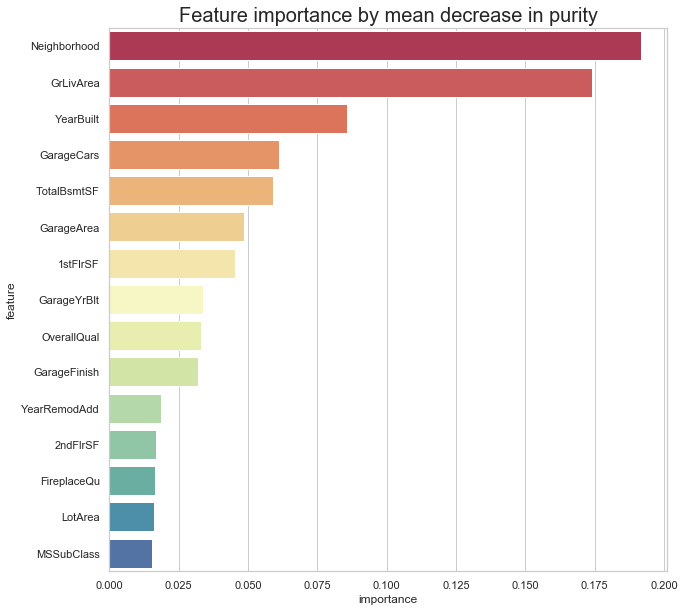

In [264]:
sk_feat_imp = feat_df(X_train.columns, grid_search.best_estimator_.feature_importances_)
plot_imp(sk_feat_imp[:15], 'Feature importance by mean decrease in purity')
sns.set_style("whitegrid")
# plt.savefig('../src/visualization/feat_imp_purity.png', dpi=300)

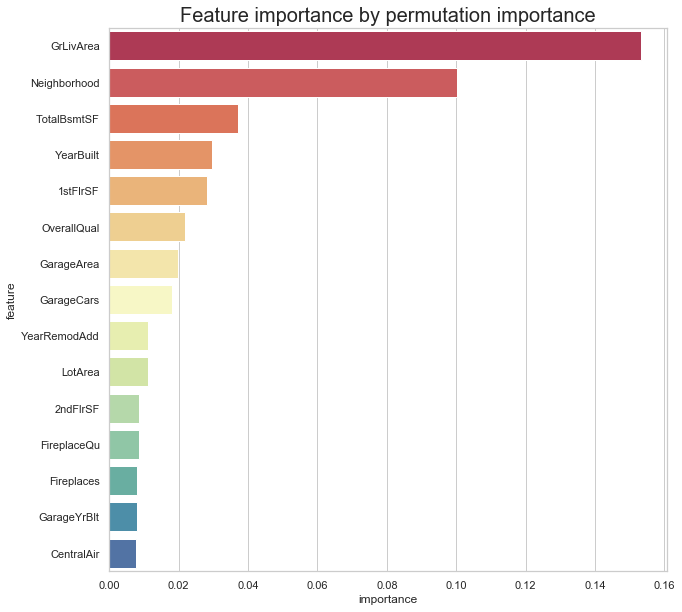

In [265]:
plot_imp(rfpimp_perm[:15], 'Feature importance by permutation importance')
sns.set_style("whitegrid")
# plt.savefig('../src/visualization/feat_imp_perm.png', dpi=300)

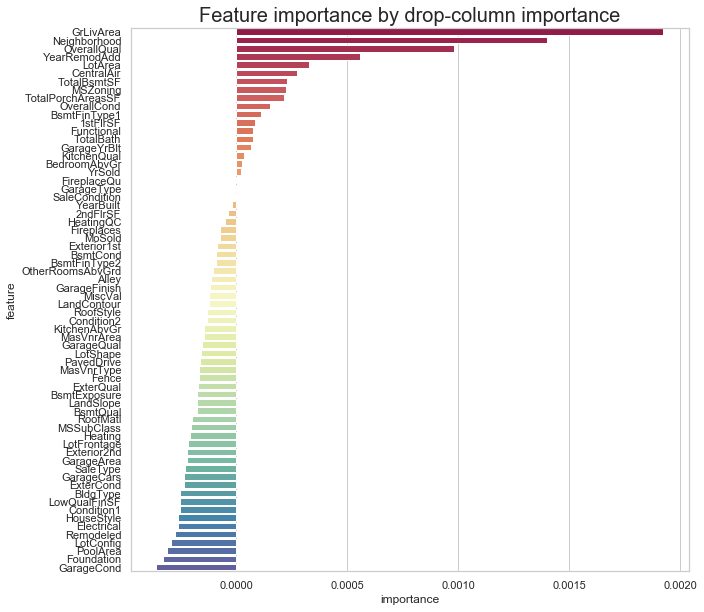

In [266]:
plot_imp(drop_col_feat.reset_index().sort_values('Importance', ascending = False), 'Feature importance by drop-column importance')
sns.set(rc = {'figure.figsize':(20, 20)})
sns.set_style("whitegrid")
# plt.savefig('../src/visualization/feat_imp_dropcol.png', dpi=300)

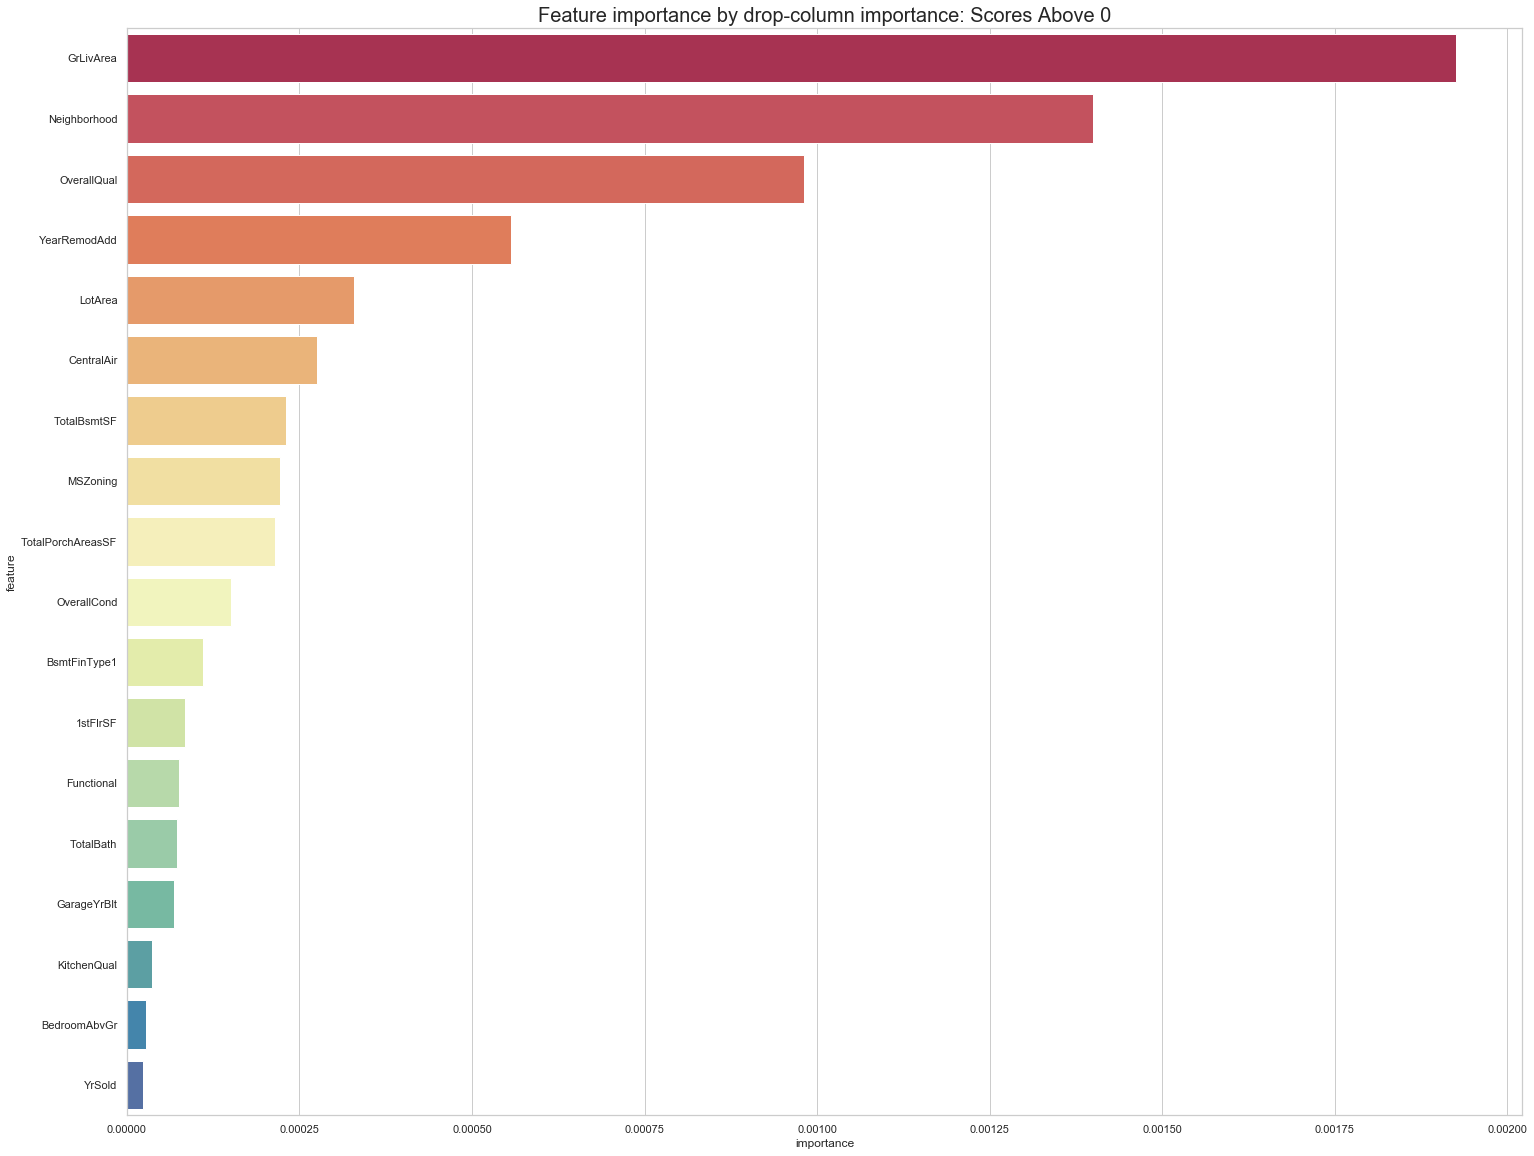

In [501]:
plot_imp(drop_col_feat.reset_index().sort_values('Importance', ascending = False)[:18], 'Feature importance by drop-column importance: Scores Above 0')
sns.set(rc = {'figure.figsize':(25, 20)})
sns.set_style("whitegrid")
# plt.savefig('../src/visualization/feat_imp_dropcol_pos.png', dpi=300)

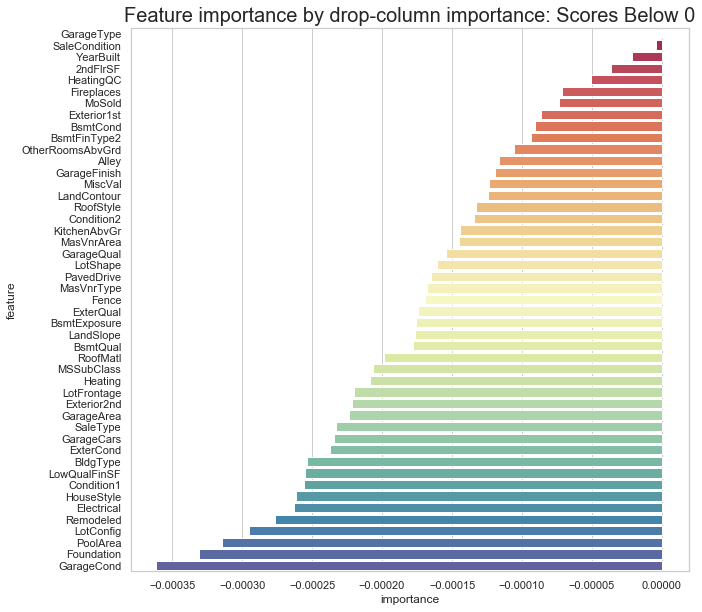

In [268]:
plot_imp(drop_col_feat.reset_index().sort_values('Importance', ascending = False)[-47:], 'Feature importance by drop-column importance: Scores Below 0')
sns.set_style("whitegrid")
# plt.savefig('../src/visualization/feat_imp_dropcol_neg.png', dpi=300)

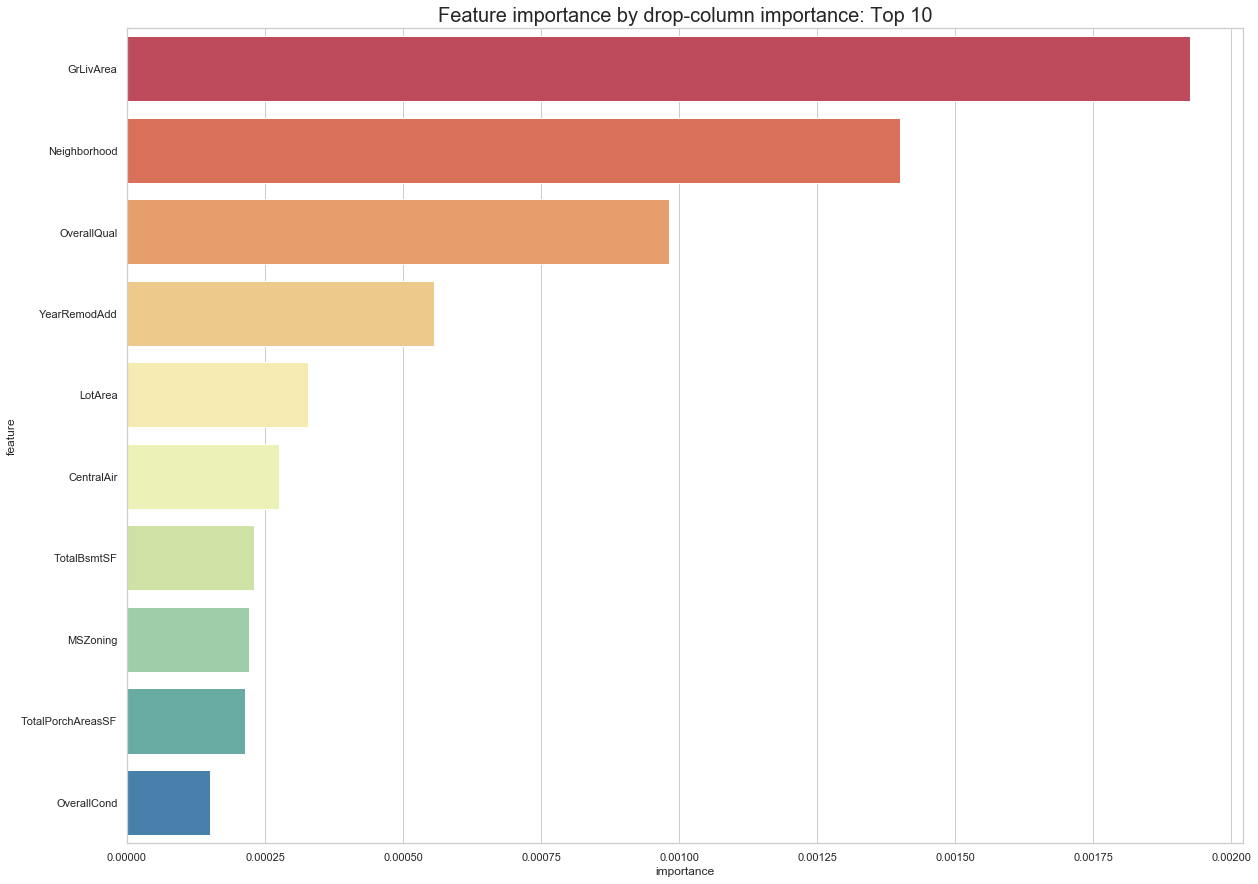

In [493]:
plot_imp(drop_col_feat.reset_index().sort_values('Importance', ascending = False)[:10], 'Feature importance by drop-column importance: Top 10')
sns.set(rc = {'figure.figsize':(25, 20)})
sns.set_style("whitegrid")
# plt.savefig('../src/visualization/feat_imp_dropcol_pos_2.png', dpi=300)

In [504]:
drop_col_feat.reset_index().sort_values('Importance', ascending = False)[:10]

,Feature,Importance
0,GrLivArea,0.001925
1,Neighborhood,0.001399
2,OverallQual,0.000981
3,YearRemodAdd,0.000557
4,LotArea,0.000329
5,CentralAir,0.000275
6,TotalBsmtSF,0.000230
7,MSZoning,0.000222
8,TotalPorchAreasSF,0.000214
9,OverallCond,0.000151


### Deep Dive

Examine multicollinearity of predictor feature `grlivarea`, which represents "Above grade (ground) living area square feet":

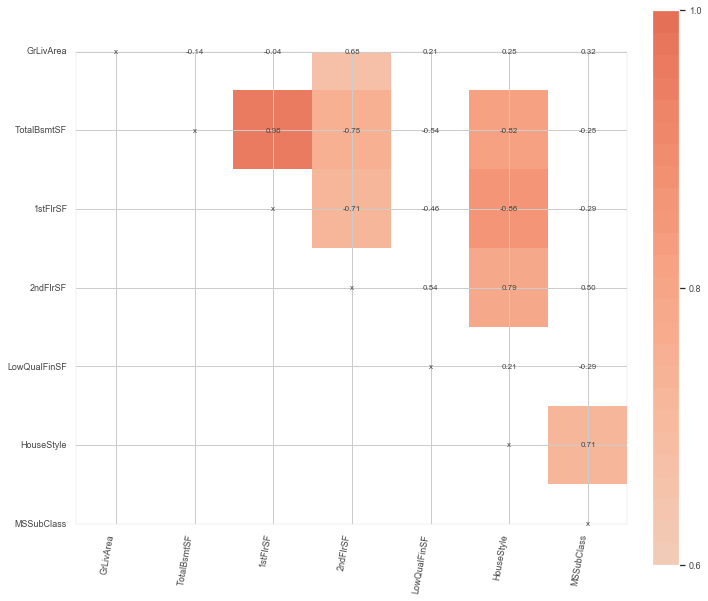

In [269]:
# print_all(feature_corr_matrix(X_train)['GrLivArea'].sort_values(ascending=False))
grlivarea_corr = feature_corr_matrix(X_train).loc[['GrLivArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','HouseStyle','MSSubClass'], ['GrLivArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','HouseStyle','MSSubClass']]
plot_corr_heatmap(grlivarea_corr)
# plt.savefig('../src/visualization/grlivarea_corr.png', dpi=300)

Examine feature dependence of predictor feature `grlivarea`:

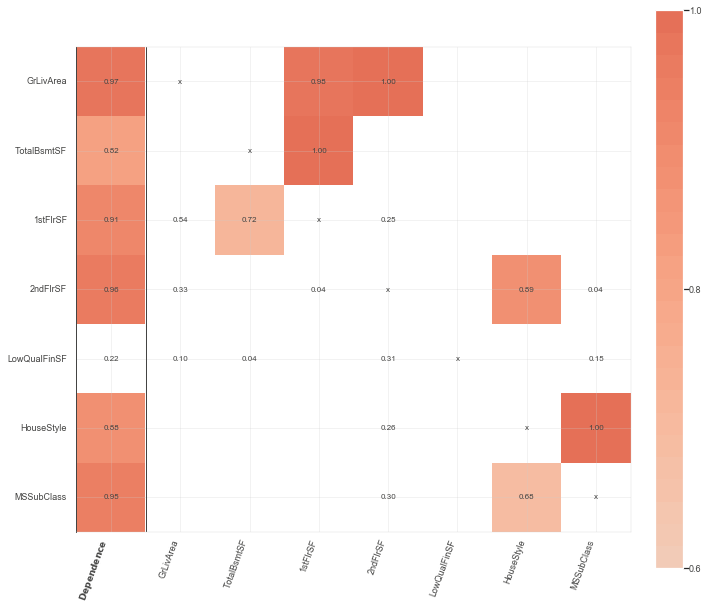

In [270]:
# print_all(feat_dep.loc['GrLivArea'])
grlivarea_dep = feat_dep.loc[['GrLivArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','HouseStyle','MSSubClass'], ['Dependence','GrLivArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','HouseStyle','MSSubClass']].reindex()
plot_dependence_heatmap(grlivarea_dep)
# plt.savefig('../src/visualization/grlivarea_dep.png', dpi=300)

Examine multicollinearity of predictor feature `OverallQual`:

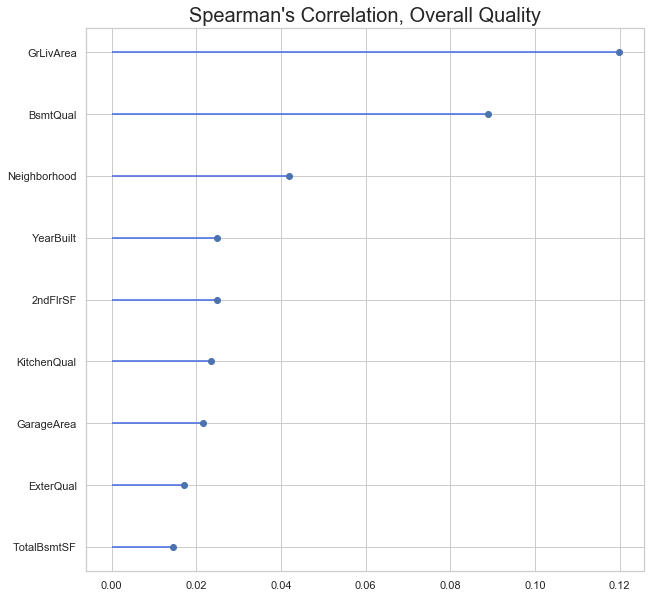

In [440]:
pd.set_option('display.max_rows', len(feature_corr_matrix(X_train)['OverallQual']))
overallqual_corr = pd.DataFrame(feature_corr_matrix(X_train)['OverallQual'].sort_values(ascending=False))
overallqual_corr[1:11]
# overallqual_corr.tail(10).sort_values('OverallQual',ascending=True)
overallqual_corr_10 = overallqual_dep[2:11].reset_index()
overallqual_corr_10.columns = ['Feature', 'Correlation']

# Reorder values
ordered_qualc = overallqual_corr_10.sort_values(by='Correlation')
my_range=range(1,len(ordered_qualc.index)+1)
 
# Lollipop chart
plt.title("Spearman's Correlation, Overall Quality", fontsize=20)
plt.hlines(y=my_range, xmin=0, xmax=ordered_qualc['Correlation'], color='royalblue')
plt.plot(ordered_qualc['Correlation'], my_range, 'o')
plt.yticks(my_range, ordered_qualc['Feature'])
plt.savefig('../src/visualization/overallqual_corr_final.png', dpi=300)
plt.show()

Examine feature dependence of predictor feature `OverallQual`:

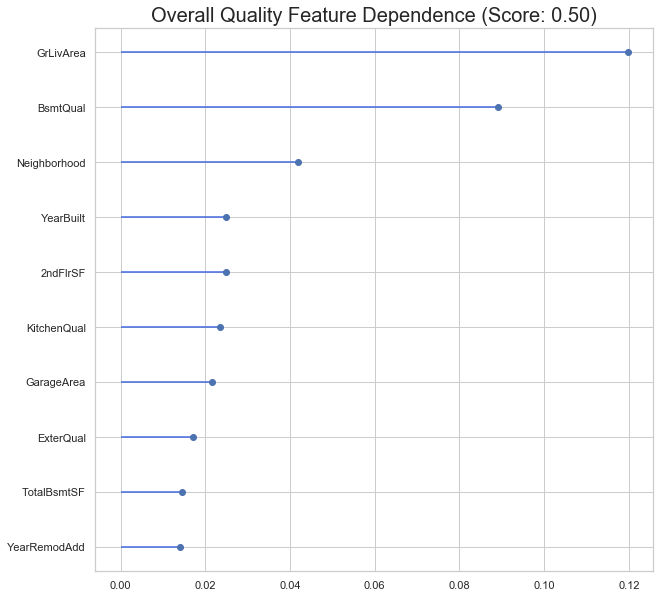

In [439]:
pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', len(mssubclass_dep))
overallqual_dep = pd.DataFrame(feat_dep.loc['OverallQual'])
overallqual_dep = pd.DataFrame(overallqual_dep.loc[overallqual_dep['OverallQual'] > 0, 'OverallQual']).sort_values('OverallQual',ascending=False)
overallqual_dep_10 = overallqual_dep[1:12].reset_index()
overallqual_dep_10.columns = ['Feature', 'Dependence']
overallqual_dep_10 = overallqual_dep_10[1:]

# Reorder values
ordered_quald = overallqual_dep_10.sort_values(by='Dependence')
my_range=range(1,len(ordered_quald.index)+1)
 
# Lollipop chart
plt.title('Overall Quality Feature Dependence (Score: 0.50)', fontsize=20)
plt.hlines(y=my_range, xmin=0, xmax=ordered_quald['Dependence'], color='royalblue')
plt.plot(ordered_quald['Dependence'], my_range, 'o')
plt.yticks(my_range, ordered_quald['Feature'])
plt.savefig('../src/visualization/overallqual_dep_final.png', dpi=300)
plt.show()

Examine multicollinearity of predictor feature `MSSubClass`:

In [358]:
pd.set_option('display.max_rows', len(feature_corr_matrix(X_train)['MSSubClass']))
mssubclass_corr = pd.DataFrame(feature_corr_matrix(X_train)['MSSubClass'].sort_values(ascending=False))

mssubclass_corr[:10]

,MSSubClass
MSSubClass,1.0000
YearBuilt,0.5733
GarageFinish,0.5425
Neighborhood,0.5348
Foundation,0.4960
GarageType,0.4892
HouseStyle,0.4748
GarageYrBlt,0.4457
Exterior2nd,0.4407
GarageCars,0.4314


Examine feature dependence of predictor feature `MSSubClass`:

In [323]:
pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', len(mssubclass_dep))
mssubclass_dep = pd.DataFrame(feat_dep.loc['MSSubClass'])
ssubclass_dep = pd.DataFrame(mssubclass_dep.loc[mssubclass_dep['MSSubClass'] > 0, 'MSSubClass'])
ssubclass_dep

,MSSubClass
Dependence,0.946657
MSSubClass,1
LotFrontage,0.00100152
LotArea,0.0883389
Neighborhood,0.00640102
BldgType,0.170688
HouseStyle,0.683874
YearBuilt,0.88289
TotalBsmtSF,0.00332261
1stFlrSF,0.00566661


In [324]:
pd.reset_option('display.max_rows')